In [63]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer

import shap

In [64]:
df = pd.read_csv("final.csv")
df.head()

,TotalRevenue,AvgRevenuePerClaim,RevenueStd,RevenuePerBeneficiary,DeductibleRatio,TotalClaims,UniquePatients,ClaimsPerPatient,InpatientRatio,HighCostRatio,...,AvgLengthOfStay,AvgChronicBurden,ShortNoteRatio,HighCostShortNoteRatio,AvgWordCount,MedicalTermDensity,ClaimAfterDeathCount,AgeStd,RevenueMedianGap,PotentialFraud
0,104640,4185.600000,10796.091144,4185.600000,0.051032,25,24,1.000000,0.200000,0.200000,...,1.440000,1.464000,0.000000,0.000000,537.280000,2.280000,0,11.915256,3785.600000,0
1,605670,4588.409091,7309.794729,5132.796610,0.109442,132,117,1.118644,0.469697,0.469697,...,3.674242,1.553030,0.022727,0.022727,458.977273,2.515152,0,13.461823,2838.409091,1
2,52170,350.134228,689.963754,375.323741,0.005942,149,138,1.071942,0.000000,0.060403,...,1.429530,1.576510,0.006711,0.000000,511.402685,2.751678,0,12.918061,280.134228,0
3,280910,241.124464,491.556392,566.350806,0.013171,1165,495,2.348790,0.000000,0.023176,...,1.088412,1.580601,0.015451,0.000000,486.928755,2.706438,0,13.357434,171.124464,1
4,33710,468.194444,1433.769116,571.355932,0.096823,72,58,1.220339,0.041667,0.055556,...,0.958333,1.600000,0.055556,0.013889,428.208333,2.513889,0,14.628679,388.194444,0


In [65]:
def rule_engine(row):

    # CRITICAL
    if row["ClaimAfterDeathCount"] > 0:
        return "CRITICAL: Claim After Death"

    if row["InpatientRatio"] > 0.95 and row["AvgLengthOfStay"] < 1:
        return "CRITICAL: Impossible Stay Pattern"

    # HIGH RISK
    if row["ClaimsPerPatient"] > 10:
        return "HIGH: Excessive Repeat Billing"

    if row["HighCostRatio"] > 0.80:
        return "HIGH: Too Many High Cost Claims"

    if row["RevenueMedianGap"] > 20000:
        return "HIGH: Cost Skew"

    # MEDIUM
    if row["ShortNoteRatio"] > 0.70:
        return "MEDIUM: Weak Documentation"

    if row["MedicalTermDensity"] < 2:
        return "MEDIUM: Low Clinical Detail"

    return "PASS"

In [66]:

df["RuleFlag"] = df.apply(rule_engine, axis=1)

rule_fail = df[df["RuleFlag"] != "PASS"]
rule_pass = df[df["RuleFlag"] == "PASS"]

In [67]:
X = rule_pass.drop(columns=["PotentialFraud","RuleFlag"])
y = rule_pass["PotentialFraud"]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [69]:
pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

In [70]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'mean'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If 

In [71]:
pred = pipeline.predict(X_test)
prob = pipeline.predict_proba(X_test)[:,1]

In [72]:
print(classification_report(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, prob))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       855
           1       0.76      0.45      0.56        92

    accuracy                           0.93       947
   macro avg       0.85      0.72      0.76       947
weighted avg       0.93      0.93      0.92       947

ROC AUC: 0.9376430205949655


In [73]:
importance = pd.Series(
    pipeline.named_steps["model"].coef_[0],
    index=X.columns
)

importance.sort_values(ascending=False)

RevenuePerBeneficiary     0.972108
TotalRevenue              0.965561
RevenueStd                0.836539
TotalClaims               0.643518
HighCostRatio             0.552092
ClaimsPerPatient          0.376812
RevenueMedianGap          0.344668
AvgDiagnosisCount         0.199878
AvgLengthOfStay           0.191016
AgeStd                    0.168407
AvgWordCount              0.149220
AvgProcedureCount         0.135155
UniquePatients            0.099050
ShortNoteRatio            0.006183
ClaimAfterDeathCount      0.000000
InpatientRatio           -0.047174
HighCostShortNoteRatio   -0.075825
AvgChronicBurden         -0.105765
DeductibleRatio          -0.106151
MedicalTermDensity       -0.152883
AvgRevenuePerClaim       -2.058697
dtype: float64

In [74]:
explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_train
)

shap_values = explainer(X_test)

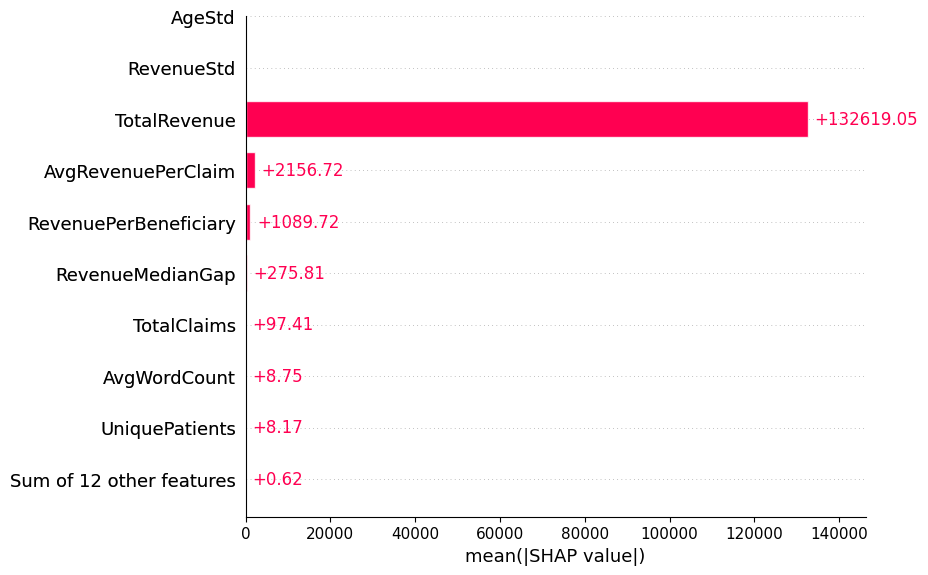

In [75]:
shap.plots.bar(shap_values)

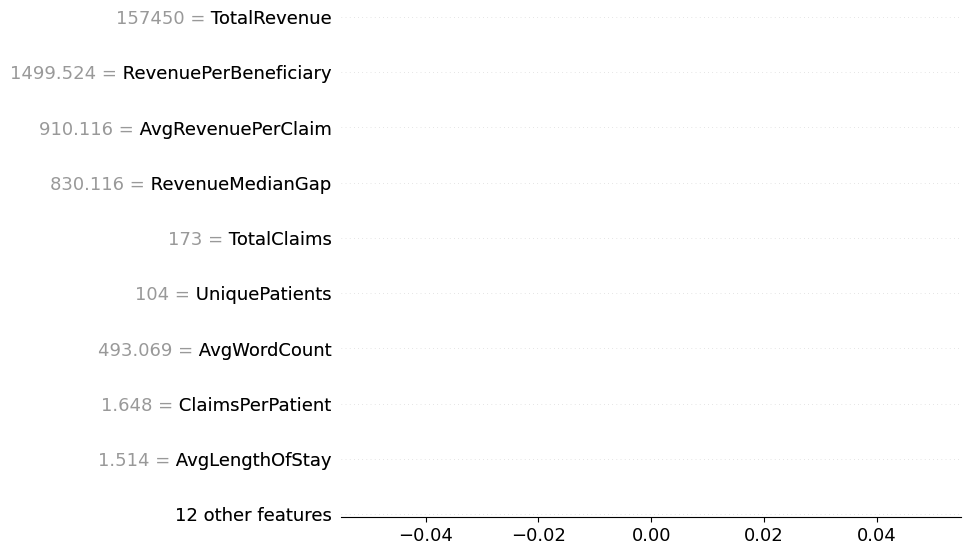

In [76]:
shap.plots.waterfall(shap_values[0])

In [77]:
df["RiskScore"] = pipeline.predict_proba(
    df[X.columns]
)[:,1]

In [78]:
def final_decision(row):

    if row["RuleFlag"] != "PASS":
        return row["RuleFlag"]

    if row["RiskScore"] > 0.80:
        return "ML HIGH RISK"

    if row["RiskScore"] > 0.60:
        return "ML MEDIUM RISK"

    return "LOW RISK"

df["FinalDecision"] = df.apply(final_decision, axis=1)

In [79]:
df.to_csv("fraud_predictions.csv", index=False)